In [2]:
# !pip3 freeze > requirements.txt

In [154]:
# !pip install plotly

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Obtaining dependency information for plotly from https://files.pythonhosted.org/packages/a8/07/72953cf70e3bd3a24cbc3e743e6f8539abe6e3e6d83c3c0c83426eaffd39/plotly-5.18.0-py3-none-any.whl.metadata
  Obtaining dependency information for tenacity>=6.2.0 from https://files.pythonhosted.org/packages/f4/f1/990741d5bb2487d529d20a433210ffa136a367751e454214013b441c4575/tenacity-8.2.3-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 2.9 MB/s eta 0:00:0000:0100:01


In [163]:
import pandas as pd
import datetime as datetime
import numpy as np
import seaborn as sns
from sentence_transformers import SentenceTransformer
import nltk
import re
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
import plotly.express as px


# nltk.download('punkt')

In [5]:
imdb = pd.read_parquet('../data/raw/imdb_reviews/cleaned_sorta.parquet')
imdb['scrape_date'] = [datetime.date(2023, 10, 21) for i in range(len(imdb))]
imdb['is_rotten'] = [np.nan for i in range(len(imdb))]
imdb['source'] = ['imdb' for i in range(len(imdb))]
imdb.score = imdb.score.apply(lambda x: x/10)




rt_aud = pd.read_csv('../data/raw/reviews/RT_audience.csv')
rt_aud['scrape_date'] = [datetime.date(2023, 10, 21) for i in range(len(rt_aud))]
rt_aud['title'] = [np.nan for i in range(len(rt_aud))]
rt_aud['is_rotten'] = [np.nan for i in range(len(rt_aud))]
rt_aud['source'] = ['rt_aud' for i in range(len(rt_aud))]




rt_crit = pd.read_csv('../data/raw/reviews/RT_critics.csv')
rt_crit['scrape_date'] = [datetime.date(2023, 10, 21) for i in range(len(rt_crit))]
rt_crit['title'] = [np.nan for i in range(len(rt_crit))]
rt_crit['score'] = [np.nan for i in range(len(rt_crit))]
rt_crit['source'] = ['rt_crit' for i in range(len(rt_crit))]





metacritic = pd.read_json('../data/raw/reviews/metacritic.json')
metacritic['title'] = [np.nan for i in range(len(metacritic))]
metacritic['is_rotten'] = [np.nan for i in range(len(metacritic))]
metacritic['source'] = ['metacritic' for i in range(len(metacritic))]



In [6]:
df_list = [imdb, rt_aud, rt_crit, metacritic]
for i in df_list:
    print(sorted(i.columns))

['date', 'is_rotten', 'movie', 'score', 'scrape_date', 'source', 'text', 'title', 'url', 'user']
['date', 'is_rotten', 'movie', 'score', 'scrape_date', 'source', 'text', 'title', 'url', 'user']
['date', 'is_rotten', 'movie', 'score', 'scrape_date', 'source', 'text', 'title', 'url', 'user']
['date', 'is_rotten', 'movie', 'score', 'scrape_date', 'source', 'text', 'title', 'url', 'user']


In [7]:
str1 = 'spiderman-balls'.replace('spiderman', 'spider-man')

str1

'spider-man-balls'

In [8]:
main_df = pd.concat(df_list)
print(len(main_df) - len(main_df.drop_duplicates()))
main_df = main_df.drop_duplicates()
main_df.loc[main_df['score'] == 0.0, ['score']]  = 1.0
def spiderman_fix(movie):
    if movie.startswith('spiderman'):
        return movie.replace('spiderman', 'spider-man')
    else:
        return movie
def guardians_fix(x):
    if 'vol-' in x:
        return x.replace('vol-', 'vol.-')
    else:
        return x

main_df.movie = main_df.movie.apply(lambda x: spiderman_fix(x))
main_df.movie = main_df.movie.apply(lambda x: guardians_fix(x))
main_df.reset_index(inplace=True)

265


In [9]:
main_df.score.value_counts()

score
10.0    119907
8.0      61449
9.0      43976
7.0      39072
6.0      31970
1.0      18446
5.0      17439
4.0      15751
2.0      11211
3.0       9614
Name: count, dtype: int64

In [10]:
scores = []
for film in set(main_df.movie):
    new_df = main_df.query('movie == @film')
    scores.append([film, new_df.score.median(), new_df.score.mean()])
    # print('median score:', new_df.score.median())
    # print('mean score:', new_df.score.mean())

/var/folders/7n/1v9m4ykn66ddbcxt5nwgg9280000gn/T/ipykernel_68441/2165002354.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scores.Mean_score, bins=20)


<Axes: xlabel='Mean_score', ylabel='Density'>

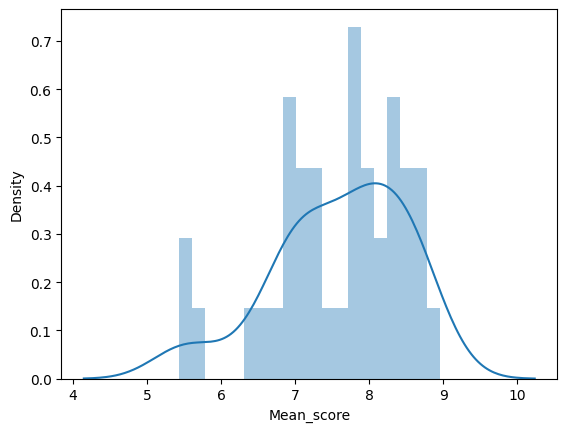

In [11]:
scores = pd.DataFrame(data=scores, columns=['Movie', 'Median_Score', 'Mean_score'])
sns.distplot(scores.Mean_score, bins=20)

<Axes: >

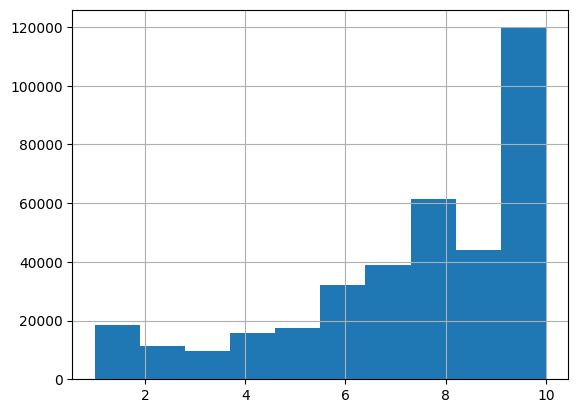

In [12]:
main_df.score.hist(bins=10)

<Axes: >

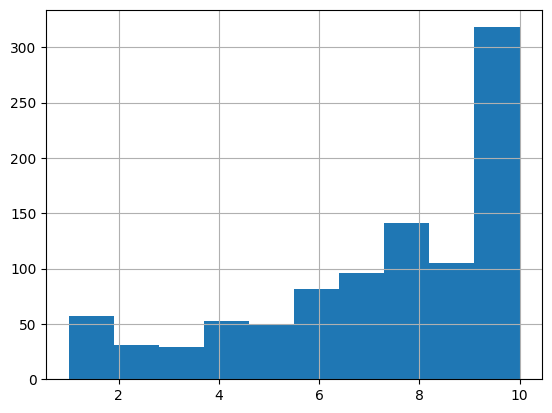

In [13]:
main_df.sample(n=1000).score.hist(bins=10)

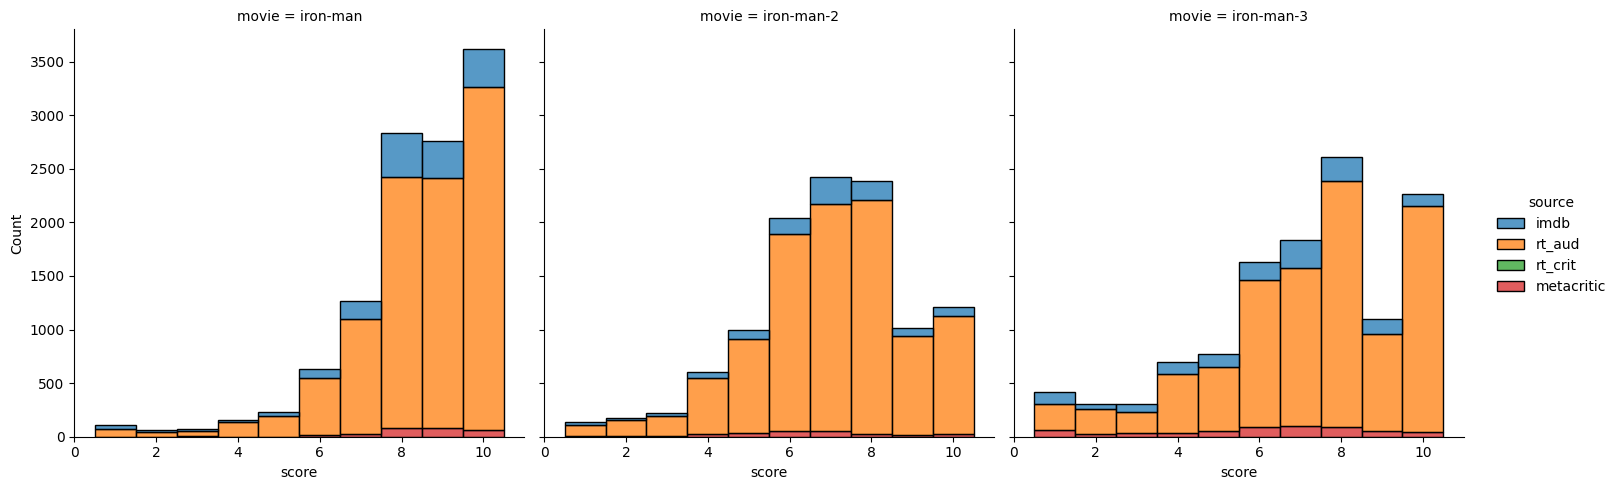

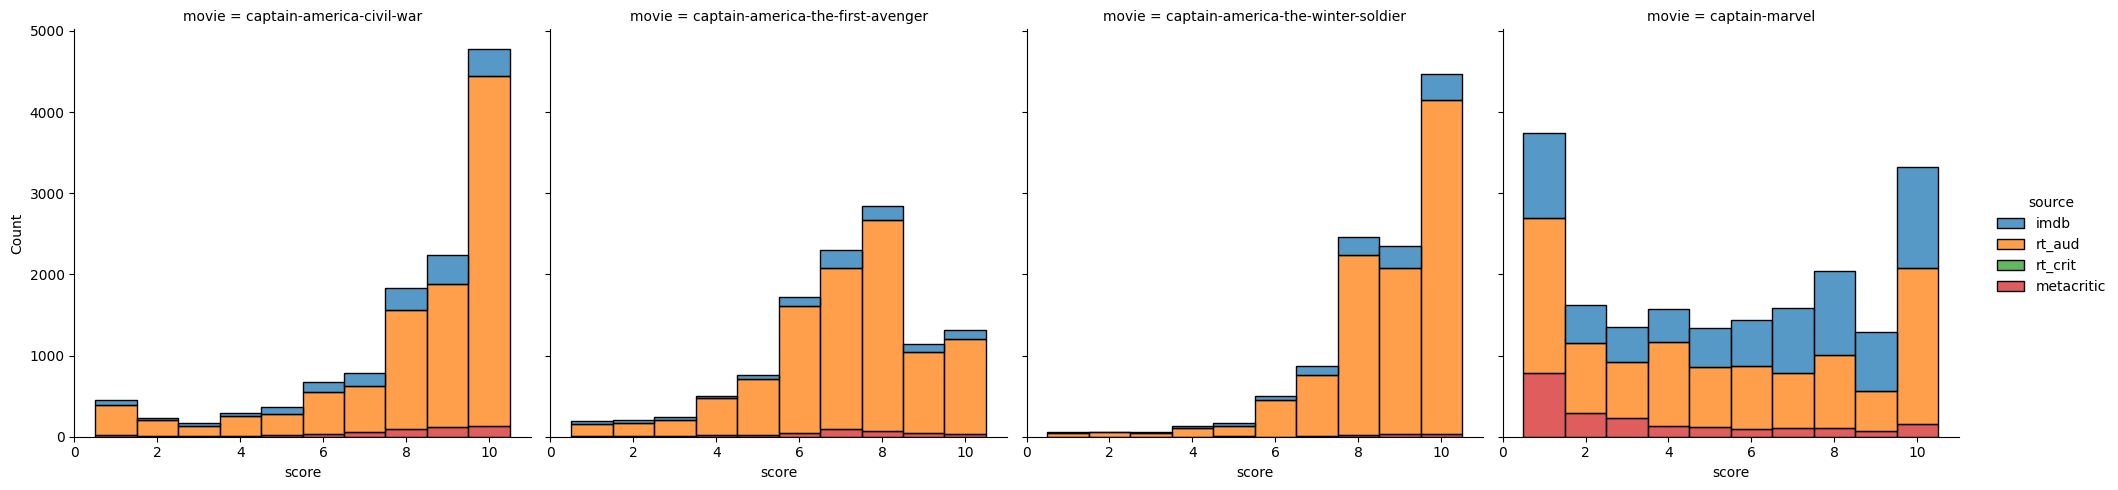

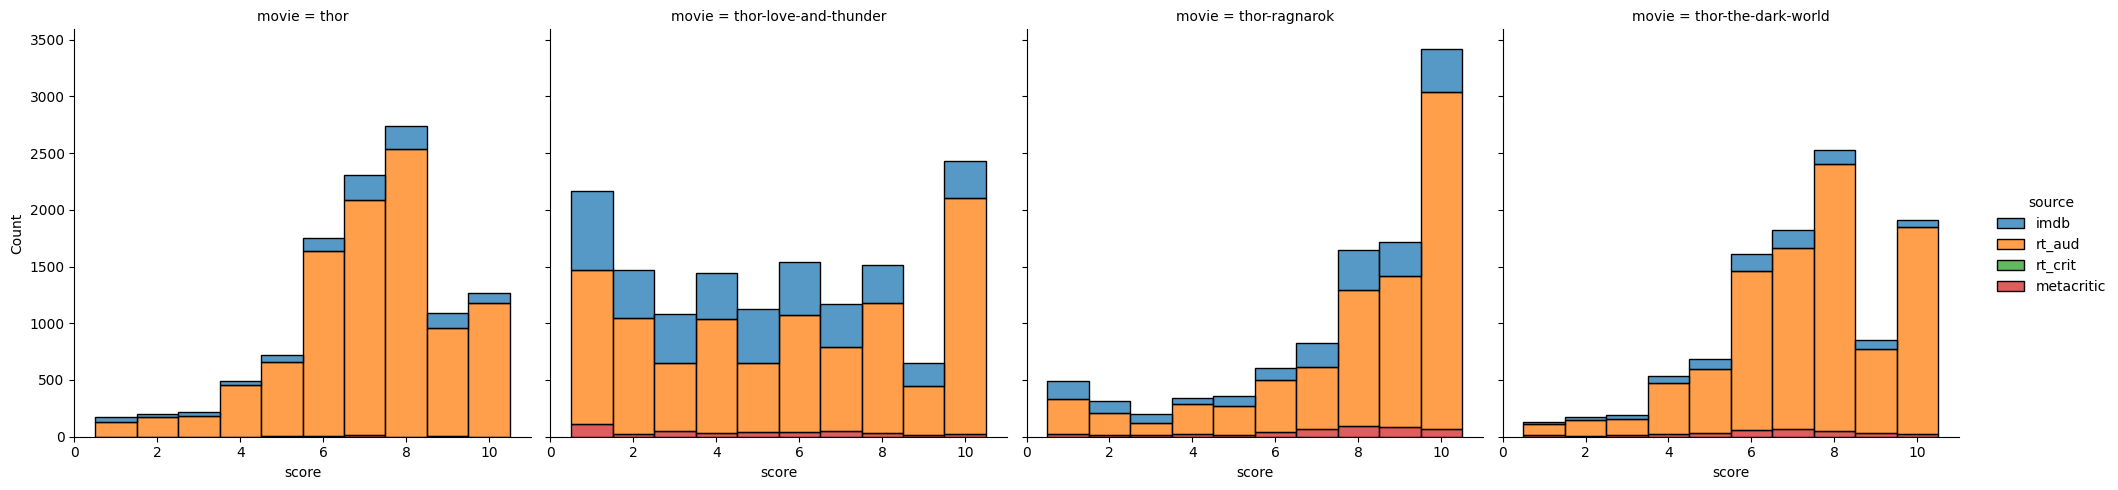

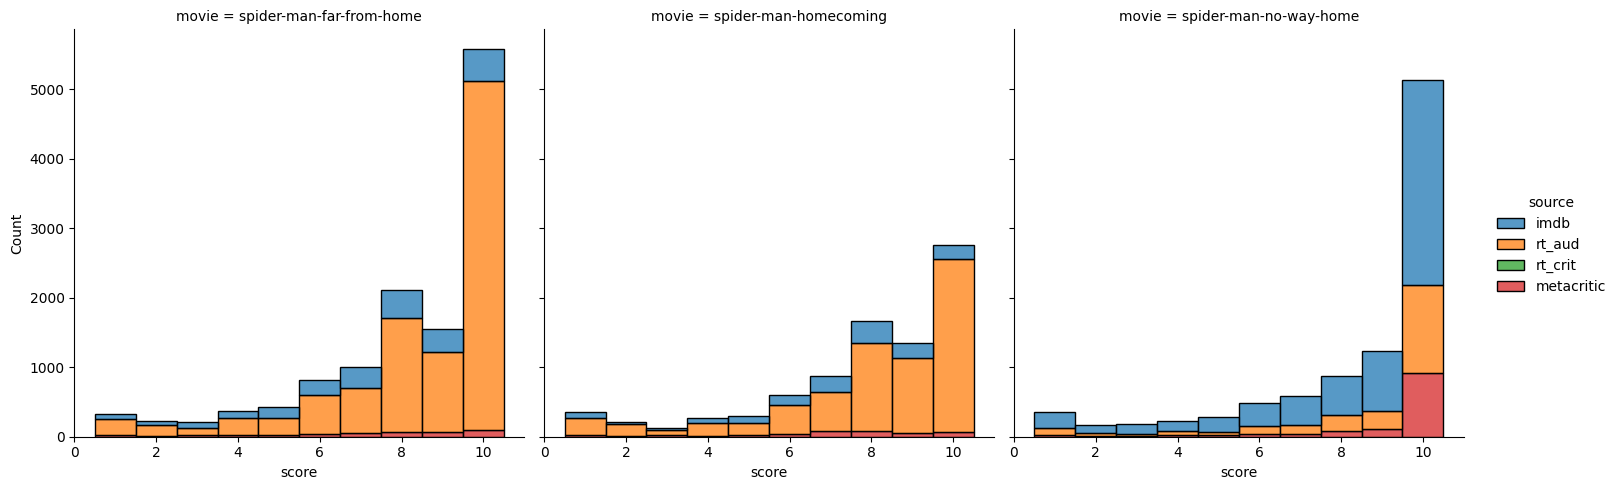

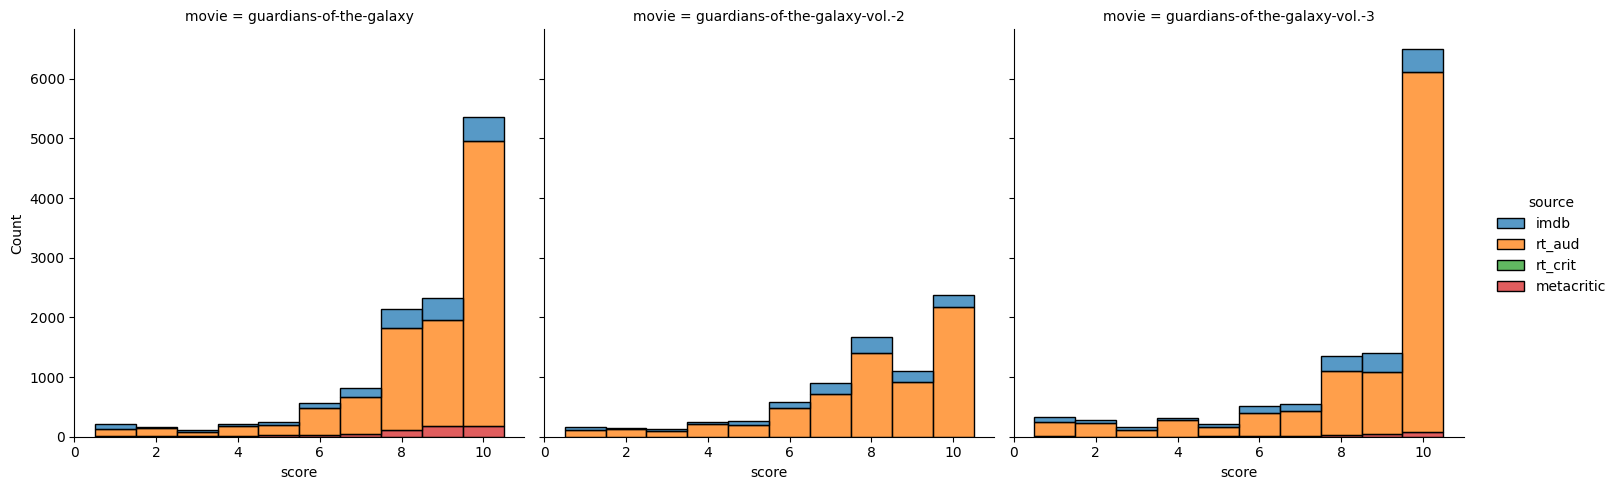

In [14]:
def map_franchise(franchise, df):
    cap = df[df['movie'].str.startswith(franchise)]
    sns.displot(data= cap, x='score', col='movie', bins=10, fill=True, discrete=True, hue='source', multiple = 'stack')
map_franchise('iron-man', main_df)
map_franchise('captain', main_df)
map_franchise('thor', main_df)
map_franchise('spider', main_df)
map_franchise('guardians', main_df)




In [155]:
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')
main_df['text_cleaned'] = main_df.text.dropna()
main_df['text_cleaned'] = main_df.text_cleaned.astype(str)
main_df['text_cleaned'] = main_df.text_cleaned.str.lower()
main_df.text_cleaned = main_df.text_cleaned.apply(lambda s: re.sub(r"[0-9]", "number", s))
sample_data = main_df.sample(n=5000)
embeddings = sbert_model.encode(list(sample_data.text_cleaned))

KeyboardInterrupt: 

In [215]:
pca = PCA(n_components=3)
new_3d = pca.fit_transform(embeddings)
print(pca.explained_variance_ratio_)
new_3d = new_3d**3
x, y, z = [], [], []
for i, j, k in new_3d:
    x.append(i)
    y.append(j)
    z.append(k)
sample_data['x'], sample_data['y'], sample_data['z'] = x, y, z

[0.18819927 0.12733775 0.07627623]


<Axes: xlabel='x', ylabel='y'>

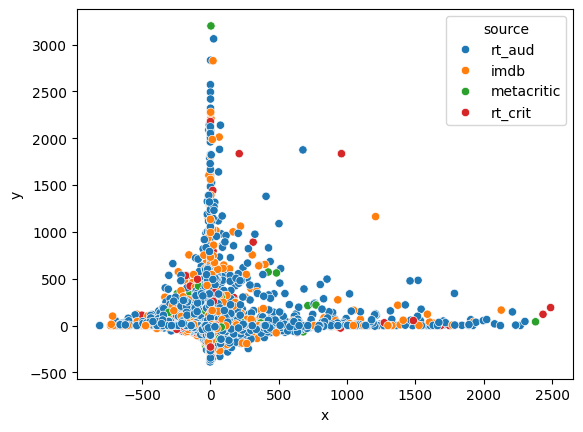

In [213]:
sns.scatterplot(data=sample_data, x='x', y='y', hue='source')

In [195]:
pca = PCA(n_components=1)
new_1d = pca.fit_transform(embeddings)
sample_data['1dim'] = new_1d

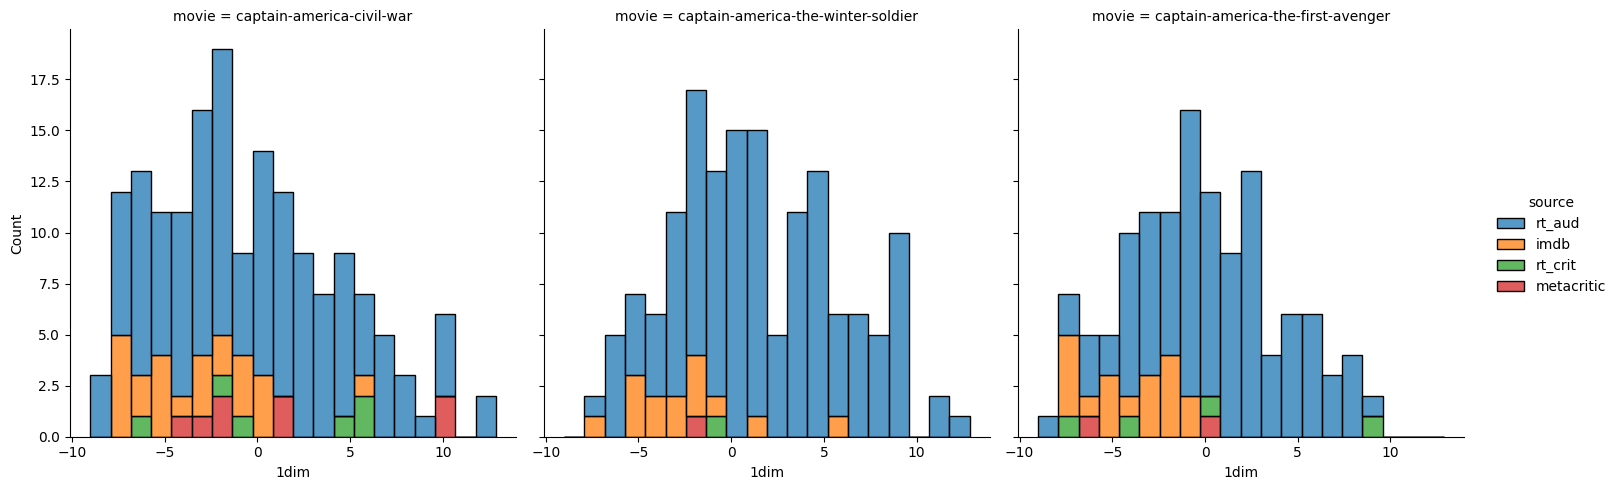

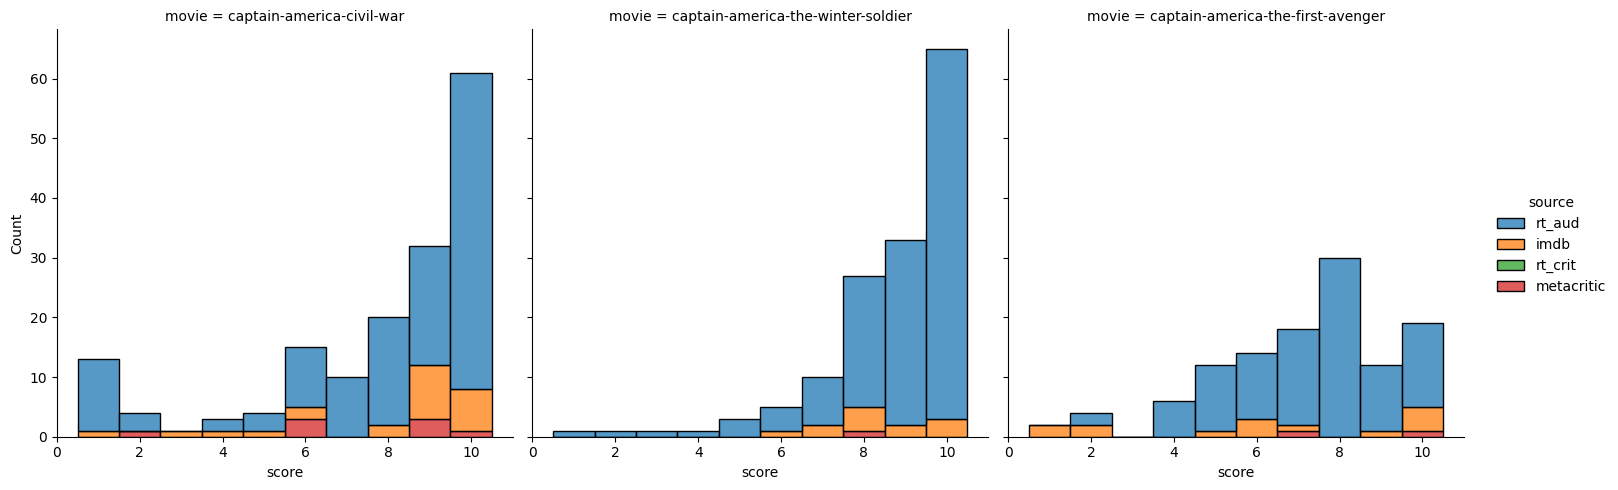

In [94]:
def plot_embeds(franchise, df):
    cap = df[df['movie'].str.startswith(franchise)]
    sns.displot(data= cap, x='1dim', col='movie',bins=20, fill=True, discrete=False, hue='source', multiple = 'stack')

plot_embeds('captain-america', sample_data)
map_franchise('captain-america', sample_data)

# plot_embeds('thor', sample_data)
# map_franchise('thor', sample_data)

# plot_embeds('eternals', sample_data)
# map_franchise('eternals', sample_data)

In [95]:
clf = IsolationForest(max_samples='auto', random_state=0, n_estimators=200)
preds = clf.fit_predict(new_2d)

In [96]:
sample_data['outlier'] = preds

In [176]:
a = sample_data.query('x > 2000').sample(n=5)
a['set'] = 'a'

b = sample_data.query('x < -500').sample(n=5)
b['set'] = 'b'


c = sample_data.query('y > 2300').sample(n=5)
c['set'] = 'c'


d = sample_data.query('abs(y) < 3 & abs(x) < 3 & z < 3').sample(n=5)
d['set'] = 'd'


f = sample_data.query('y < -100').sample(n=5)
f['set'] = 'f'


g = sample_data.query('z > 600').sample(n=5)
g['set'] = 'g'

h = sample_data.query('z < -450').sample(n=5)
h['set'] = 'h'

big_sample = pd.concat([a, b, c, d, f, g, h])

<Axes: xlabel='x', ylabel='y'>

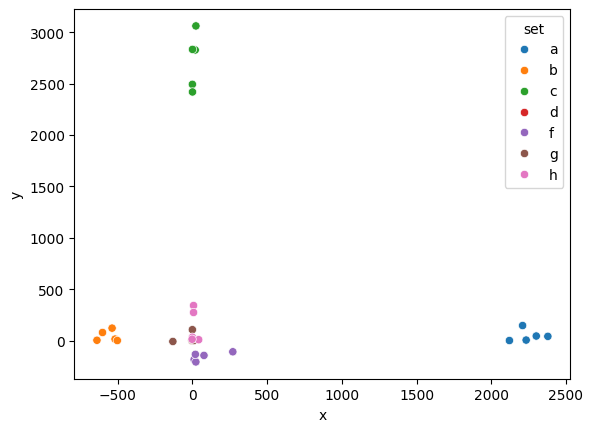

In [177]:
sns.scatterplot(big_sample, x = 'x', y='y', hue = 'set')

In [149]:
def write_set(set):
    shit = big_sample.query(f'set == "{set}"')
    for idx, i in enumerate(shit.iterrows()):
        print(idx, i[1].text, i[1].movie)
write_set('a')

0 Excellent! guardians-of-the-galaxy
1 ...so good! avengers-infinity-war
2 It was awesome! I loved it! shang-chi-and-the-legend-of-the-ten-rings
3 really good, filled with action! iron-man-3
4 Just full of awesomeness spider-man-far-from-home


In [180]:
px.scatter_3d(big_sample, x = 'x', y = 'y', z= 'z', color='set')

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'set=a<br>x=%{x}<br>y=%{y}<br>z=%{z}<extra></extra>',
              'legendgroup': 'a',
              'marker': {'color': '#636efa', 'symbol': 'circle'},
              'mode': 'markers',
              'name': 'a',
              'scene': 'scene',
              'showlegend': True,
              'type': 'scatter3d',
              'x': array([2233.5127, 2301.2417, 2209.712 , 2378.7847, 2121.5825], dtype=float32),
              'y': array([4.6099849e+00, 4.3905048e+01, 1.4590189e+02, 4.0652679e+01,
                          1.8078009e-02], dtype=float32),
              'z': array([-1.0301376e-03, -1.8993825e-02,  4.1388309e+01, -4.2691984e+00,
                          -4.9783695e-02], dtype=float32)},
             {'hovertemplate': 'set=b<br>x=%{x}<br>y=%{y}<br>z=%{z}<extra></extra>',
              'legendgroup': 'b',
              'marker': {'color': '#EF553B', 'symbol': 'circle'},
              'mode': 'markers',
              'name': 'b',
              'scene': 'scene',
              'showlegend': True,
              'type': 'scatter3d',
              'x': array([-517.41327, -537.2527 , -601.3393 , -502.1995 , -638.5609 ],
                         dtype=float32),
              'y': array([1.3998931e+01, 1.2076029e+02, 7.8312157e+01, 1.2535355e-03,
                          2.6538312e+00], dtype=float32),
              'z': array([ 0.01904404, -0.15667455, 14.317267  , 14.463135  ,  0.2459742 ],
                         dtype=float32)},
             {'hovertemplate': 'set=c<br>x=%{x}<br>y=%{y}<br>z=%{z}<extra></extra>',
              'legendgroup': 'c',
              'marker': {'color': '#00cc96', 'symbol': 'circle'},
              'mode': 'markers',
              'name': 'c',
              'scene': 'scene',
              'showlegend': True,
              'type': 'scatter3d',
              'x': array([ 0.0627521, 19.017466 ,  0.9143259,  0.70543  , 23.612427 ],
                         dtype=float32),
              'y': array([2492.795 , 2827.2349, 2832.7249, 2418.7805, 3061.2686], dtype=float32),
              'z': array([-37.73211  , -15.475242 ,  18.263002 ,  -3.9598858,  -9.385334 ],
                         dtype=float32)},
             {'hovertemplate': 'set=d<br>x=%{x}<br>y=%{y}<br>z=%{z}<extra></extra>',
              'legendgroup': 'd',
              'marker': {'color': '#ab63fa', 'symbol': 'circle'},
              'mode': 'markers',
              'name': 'd',
              'scene': 'scene',
              'showlegend': True,
              'type': 'scatter3d',
              'x': array([ 2.7425814 , -0.09479984, -0.03427962, -1.1418715 , -1.8205144 ],
                         dtype=float32),
              'y': array([-2.534151  ,  0.44590637, -0.2593674 , -1.3193252 , -0.026746  ],
                         dtype=float32),
              'z': array([ -43.331272, -201.26814 ,  -39.830284,  -61.910366,  -25.245121],
                         dtype=float32)},
             {'hovertemplate': 'set=f<br>x=%{x}<br>y=%{y}<br>z=%{z}<extra></extra>',
              'legendgroup': 'f',
              'marker': {'color': '#FFA15A', 'symbol': 'circle'},
              'mode': 'markers',
              'name': 'f',
              'scene': 'scene',
              'showlegend': True,
              'type': 'scatter3d',
              'x': array([ 11.797252,  77.63219 ,  23.204212, 270.59958 ,  20.043373],
                         dtype=float32),
              'y': array([-184.72893, -144.73352, -208.10255, -109.40158, -134.49857],
                         dtype=float32),
              'z': array([  0.11062924,  -1.6404173 ,   5.371967  , -14.9940405 ,  11.789677  ],
                         dtype=float32)},
             {'hovertemplate': 'set=g<br>x=%{x}<br>y=%{y}<br>z=%{z}<extra></extra>',
              'legendgroup': 'g',
              'marker': {'color': '#19d3f3', 'symbol': 'circle'},
              'mode': 'markers',
              'name': 'g',
              'scene': 'scene',
              'showlegend': Tru